<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/torch/notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates how to train the generator network (Section 4.2, [Scalable particle-based alternatives to EM](https://juankuntz.github.io/publication/parem/)) on the MNIST dataset using PGD.

# Setup

First, we install and import the necessary modules, and we set two paths:

* `DATASET_PATH`: Directory where we will download the MNIST dataset.
* `CHECKPOINTS_PATH`: Directory where we will save model checkpoints.

(To run the notebook locally, comment out the 'Colab setup' cell and uncomment the 'Local setup' cell.)

## Colab setup

In [ ]:
%%capture
# Set paths
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab
DATASET_PATH = '/content/ParEM/datasets/MNIST'
CHECKPOINTS_PATH = '/content/gdrive/MyDrive/ParEM/checkpoints'

# Install missing packages
!pip install torchtyping
!pip install torchmetrics[image]
!pip install wandb

# Import standard modules
import sys

# Import custom modules
!rm -rf ParEM
!git clone https://github.com/juankuntz/ParEM.git
REPOSITORY_PATH = '/content/ParEM/torch'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

## Local setup

In [ ]:
# # Import standard modules
# import sys

# sys.path.append("../")

# DATASET_PATH = '../datasets/MNIST'
# CHECKPOINTS_PATH = '../checkpoints'

## General setup

In [ ]:
# Import standard modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Import custom modules
from parem.models import NLVM  # Generator network model
from parem.algorithms import (PGD,
                              ShortRun,
                              VI,
                              AlternatingBackprop)
from parem.utils import get_mnist, load_checkpoint

# Config variables and load dataset

Next, we set the config variables:

In [ ]:
# Data setttings
N_IMAGES = 10000  # M: training set size 

# Training settings
N_BATCH = 128 # M_b: batch size for theta updates
N_EPOCHS = 100 # n_epochs = K * M_b / M where K = total number of iterations
SEED = 1 # Seed for PRNG
# Device on which to carry out computations:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OPTIMIZER = 'rmsprop'  # Theta optimizer

# Model Settings
X_DIM = 64  # d_x: dimension of latent space
LIKELIHOOD_VAR = 0.01 ** 2  # sigma^2

# PGD Settings
STEP_SIZE = 1e-4 # h: step size 
LAMBDA = 1e-3 / (STEP_SIZE * N_IMAGES)  # lambda
N_PARTICLES = 10 # N: number of particles

And we load the MNIST dataset:

In [ ]:
%%capture
mnist = get_mnist(DATASET_PATH, N_IMAGES)  # Load dataset

# Define model and training algorithm

In this notebook, we use PGD to train the generator network. We implemented the algorithm in the class `PGD'. We also implemented the baselines in the paper via their own classes:

* [Short Run MCMC](https://arxiv.org/abs/1912.01909) in a class called `ShortRun`.
* [Variational autoencoder](https://arxiv.org/pdf/1312.6114.pdf) in a class called `VI`.
* [Alternating Backpropagation](https://arxiv.org/abs/1606.08571) in a class called `AlternatingBackprop`.

The interface is similar to that of `PGD`, see `torch/parem/algorithm` for details.

In [ ]:
# Define generator network as an instance of the NLVM (Neural Latent Variable 
# Model) class:
model = NLVM(x_dim=X_DIM, sigma2=LIKELIHOOD_VAR, nc=1).to(DEVICE)

# Set up the training algorithm:
pgd = PGD(model=model,
          dataset=mnist,
          train_batch_size=N_BATCH,
          lambd=LAMBDA,
          n_particles=N_PARTICLES,
          particle_step_size=STEP_SIZE,
          device=DEVICE,
          theta_optimizer=OPTIMIZER)

# Train

We train the model by calling the `run(...)` method of the `PGD` (similarly for `ShortRun`, `VI`, and `AlternatingBackprop`). To track the training use the method's options:

* `wandb_log`: Use [Weights and Biases](https://wandb.ai/site) to log the training.
* `log_images`: Use [Weights and Biases](https://wandb.ai/site) to log images produced by model.
* `compute_stats`: Compute FID and MSE metrics throughout training.

In [ ]:
# Train:
pgd.run(N_EPOCHS, 
        CHECKPOINTS_PATH + '/mnist.pt',
        wandb_log=False,
        log_images=False,
        compute_stats=False)

...............................................................................Epoch 0: Loss 1797245.699,
...............................................................................Epoch 1: Loss 1305444.408,
...............................................................................Epoch 2: Loss 1071283.103,
...............................................................................Epoch 3: Loss 798594.747,
...............................................................................Epoch 4: Loss 591610.987,
...............................................................................Epoch 5: Loss 470890.018,
...............................................................................Epoch 6: Loss 393458.620,
...............................................................................Epoch 7: Loss 323670.744,
...............................................................................Epoch 8: Loss 272332.020,
....................................................

# Visualize particle cloud

To visualize the particle cloud we call `PGD.sample_image_posterior(...)` (similarly for `ShortRun`, `VI`, and `AlternatingBackprop`). It displays the `i`th image in the training set (first panel) and the images obtained by mapping the latent variables corresponding to the `i`th image through the trained generator network (ensuing `N_PARTICLES` panels).

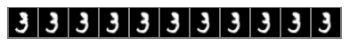

In [ ]:
i = 10  # Label of image in training set.
pgd.sample_image_posterior(i, N_PARTICLES)

# Inpainting masked images

Calling `PGD.reconstruct(img, mask=None)`, we obtain the reconstruction of `img` generated by the trained network. If `mask` is not `None`, then we pass to the network a partially occluded image and it imputes the missing pixels (specified by the `mask`).

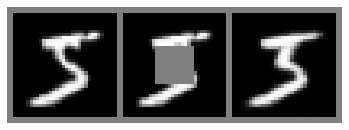

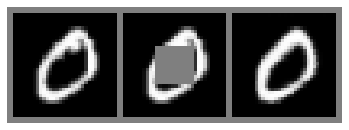

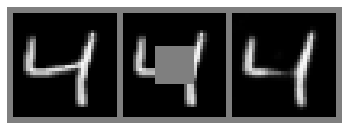

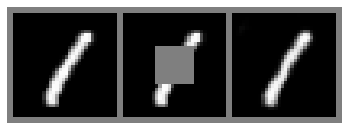

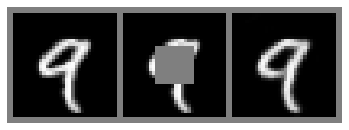

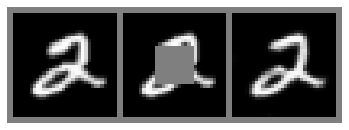

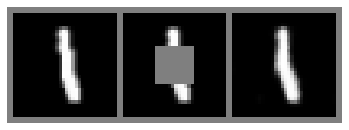

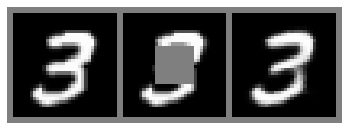

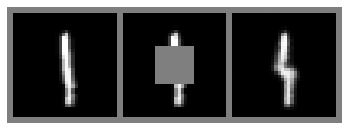

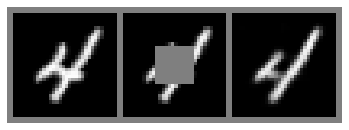

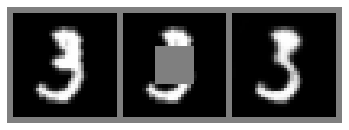

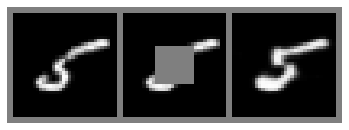

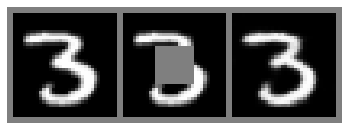

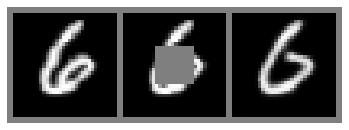

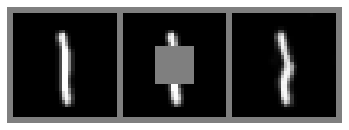

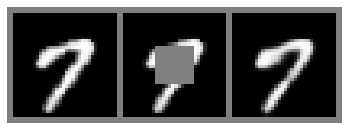

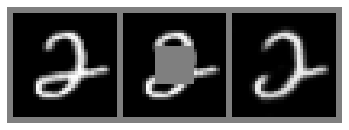

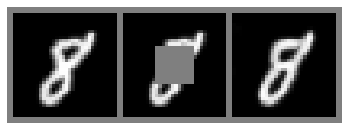

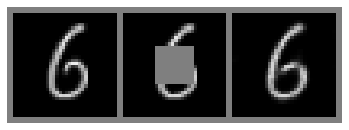

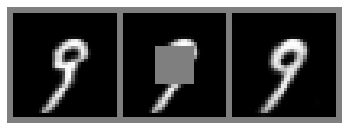

In [ ]:
n_missing_img = 20
images = mnist[:n_missing_img][0]
mask = torch.ones(mnist.height, mnist.width, dtype=torch.bool)

for i in range(10, 22):
    for j in range(10, 22):
        mask[i, j] = False

_ = pgd.reconstruct(images, mask)

# Generating synthetic images

To generate synthetic images that resemble those in the data set, we use `PGD.synthesize_images(...)`. To set the type of aggregate posterior approximation applied in the image generation, use the optional `approx_type` argument:

* `approx_type='gaussian'`: A Gaussian distribution (fitted using the sample mean and covariance).
* `approx_type='gmm'`: A Gaussian mixture model with the number of components specified by the `n_components` argument (fitted using the EM algorithm).
* `approx_type='gaussian_mixture_labels'`. A Gaussian distribution is fitted to each class label and these are mixed together using the label frequencies.

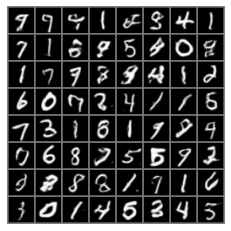

In [ ]:
_ = pgd.synthesize_images(n=64, approx_type='gmm', n_components=100)